In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import partial, update_wrapper
from collections import defaultdict
from scipy.stats import multivariate_normal, norm, uniform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

import ipywidgets as widgets
from ipywidgets import interact, interactive

# **1. Read data**

In [2]:
train_df = pd.read_csv('/kaggle/input/widsdatathon2022/train.csv')
test_df = pd.read_csv('/kaggle/input/widsdatathon2022/test.csv')

# **2. Exploratory data analysis**

In [3]:
len(train_df)

75757

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

**Missing values** for the following features:
* **year_built**:                 1837
* **energy_star_rating**:         26709
* **direction_max_wind_speed**:   41082
* **direction_peak_wind_speed**:  41811 
* **max_wind_speed**:             41082
* **days_with_fog**:              45796

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9613 non-null   float64
 6   energy_star_rating         7451 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

In [6]:
train_df.head(5)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [7]:
train_df.describe()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,...,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,...,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,...,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.528601,18939.000000
50%,5.000000,9.136700e+04,1951.000000,67.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,...,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716,37878.000000
75%,6.000000,1.660000e+05,1977.000000,85.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,...,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.277534,56817.000000
max,6.000000,6.385382e+06,2015.000000,100.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,...,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120,75756.000000


In [8]:
test_df.describe()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
count,9705.0,9.705000e+03,9613.000000,7451.000000,9705.000000,9705.000000,9705.000000,9705.000000,9705.000000,9705.000000,...,9705.000000,9705.000000,9705.000000,9705.000000,9705.0,1130.000000,1130.000000,1130.000000,588.000000,9705.000000
mean,7.0,1.632143e+05,1963.219598,64.712924,205.231190,13.520762,36.678081,60.008449,21.705100,41.634886,...,1.323029,66.820093,11.941267,0.211643,0.0,321.743363,310.194690,18.131327,150.755102,80609.000000
std,0.0,2.624759e+05,40.819953,27.935984,264.822814,12.458365,6.968520,5.874699,9.774624,5.528689,...,2.205729,30.936872,13.077936,0.615250,0.0,19.127690,38.969875,1.993348,58.760576,2801.736515
min,7.0,5.982000e+03,0.000000,1.000000,1.800000,-1.000000,27.548387,42.000000,9.000000,33.428571,...,0.000000,15.000000,1.000000,0.000000,0.0,280.000000,240.000000,14.800000,34.000000,75757.000000
25%,7.0,4.802000e+04,1929.000000,45.000000,26.500000,-1.000000,27.548387,54.000000,9.000000,36.053571,...,0.000000,39.000000,3.000000,0.000000,0.0,310.000000,270.000000,16.500000,129.000000,78183.000000
50%,7.0,8.248600e+04,1969.000000,72.000000,118.900000,15.000000,38.661290,59.000000,22.000000,41.625000,...,0.000000,77.000000,5.000000,0.000000,0.0,330.000000,320.000000,18.300000,129.000000,80609.000000
75%,7.0,1.775200e+05,1994.000000,88.000000,231.300000,21.000000,41.177419,64.000000,28.000000,45.685185,...,5.000000,79.000000,12.000000,0.000000,0.0,340.000000,340.000000,19.200000,138.000000,83035.000000
max,7.0,6.353396e+06,2016.000000,100.000000,812.000000,38.000000,50.596774,71.000000,40.000000,54.482143,...,5.000000,122.000000,41.000000,2.000000,0.0,360.000000,350.000000,23.300000,250.000000,85461.000000


## **2.0 Site eui**

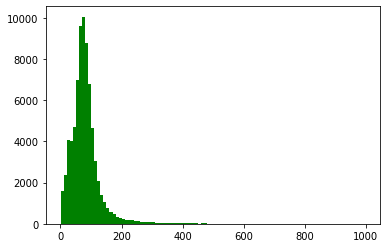

In [9]:
n, bins, patches = plt.hist(train_df['site_eui'], 100, density=False, facecolor='g')

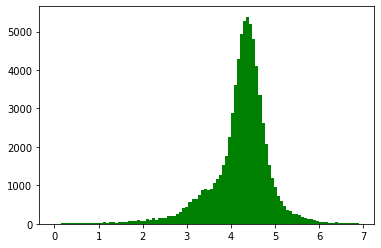

In [10]:
n, bins, patches = plt.hist(np.log(train_df['site_eui']), 100, density=False, facecolor='g')

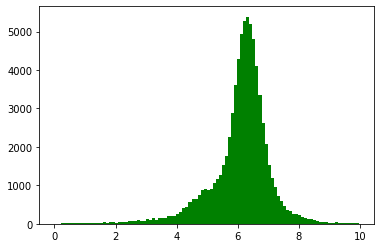

In [11]:
n, bins, patches = plt.hist(np.log2(train_df['site_eui']), 100, density=False, facecolor='g')

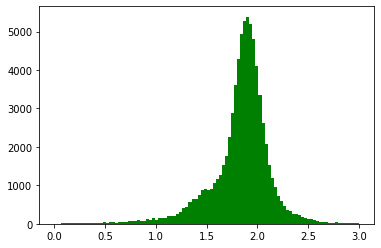

In [12]:
n, bins, patches = plt.hist(np.log10(train_df['site_eui']), 100, density=False, facecolor='g')

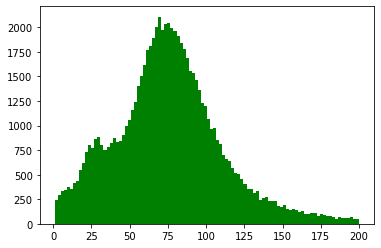

In [13]:
n, bins, patches = plt.hist(train_df.loc[train_df['site_eui'] < 200]['site_eui'], 100, density=False, facecolor='g')

## **2.1 Year factor**

<AxesSubplot:ylabel='None'>

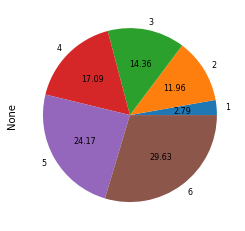

In [14]:
# year factor piechart
train_df.groupby('Year_Factor').size().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 8})

<AxesSubplot:ylabel='None'>

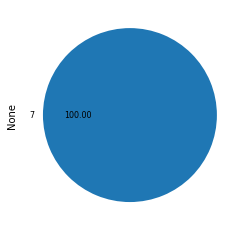

In [15]:
test_df.groupby('Year_Factor').size().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 8})

ℹ️ More than half of the **data was generated in the last two years**. The test data is all from year 7.

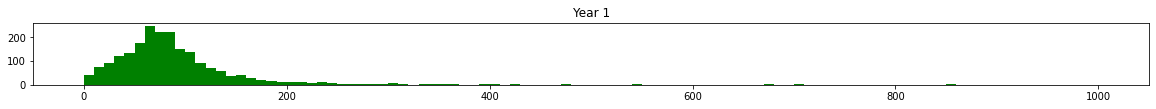

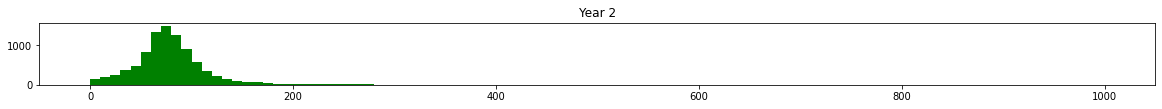

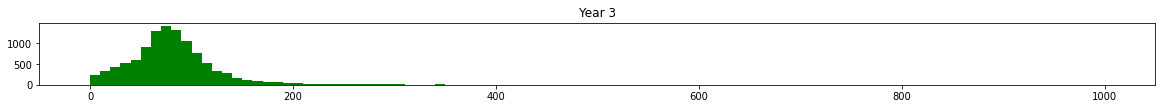

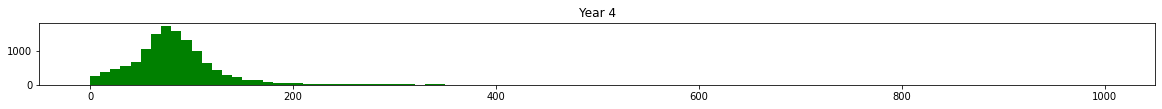

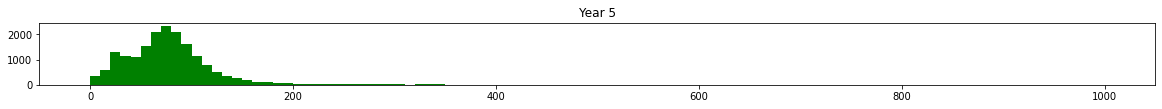

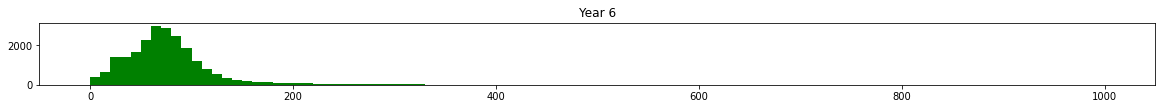

In [16]:
for i in range(1, 7):
    plt.figure(figsize=(20,8))
    plt.subplot(6, 1, i)
    plt.title(f'Year {i}')
    n, bins, patches = plt.hist(train_df.loc[train_df['Year_Factor'] == i, 'site_eui'], 100,range=(0, 1000), density=False, facecolor='g')

ℹ️ The **year does not seem to have an influence on the site_eui** as it shows the same distribution over the years.

## **2.2 State factor**

In [17]:
print(set(train_df['State_Factor']))

{'State_4', 'State_8', 'State_1', 'State_2', 'State_10', 'State_6', 'State_11'}


<AxesSubplot:ylabel='None'>

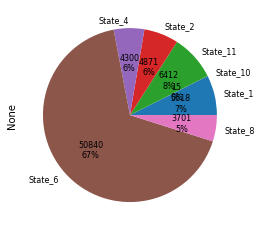

In [18]:
# state factor piechart
def label_function(val):
    return f'{val / 100 * len(train_df):.0f}\n{val:.0f}%'

train_df.groupby('State_Factor').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8})

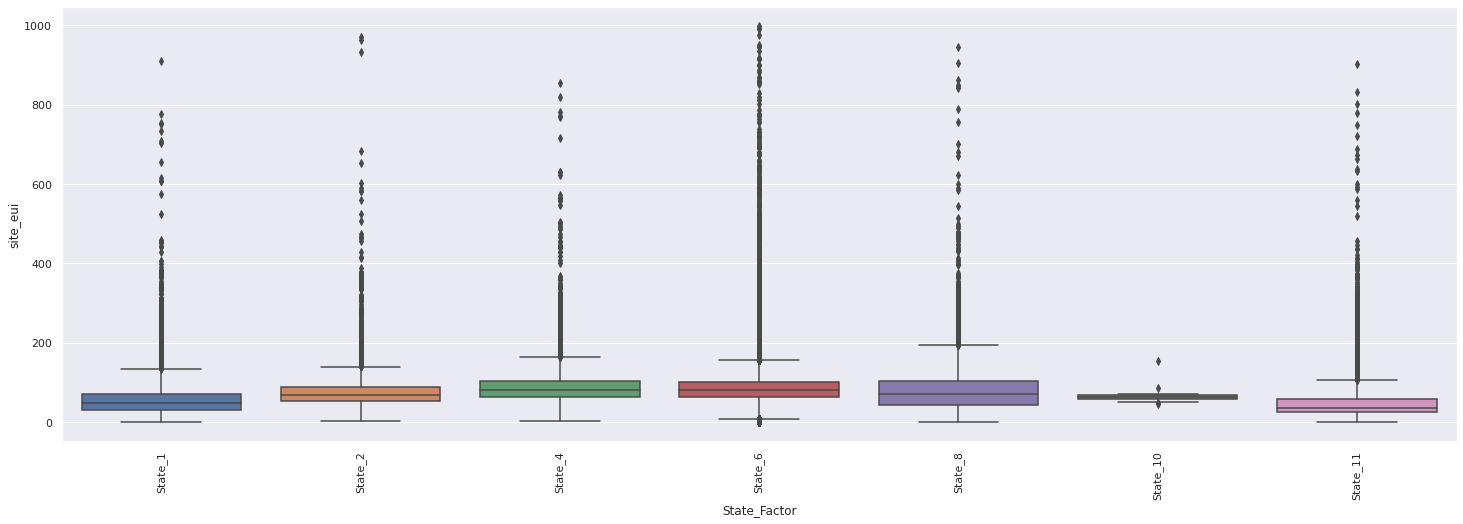

In [19]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='State_Factor', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [20]:
train_df.groupby('State_Factor').size()

State_Factor
State_1      5618
State_10       15
State_11     6412
State_2      4871
State_4      4300
State_6     50840
State_8      3701
dtype: int64

ℹ️  More than half of the records come from state 6.

## **2.3 Building class**

<AxesSubplot:ylabel='None'>

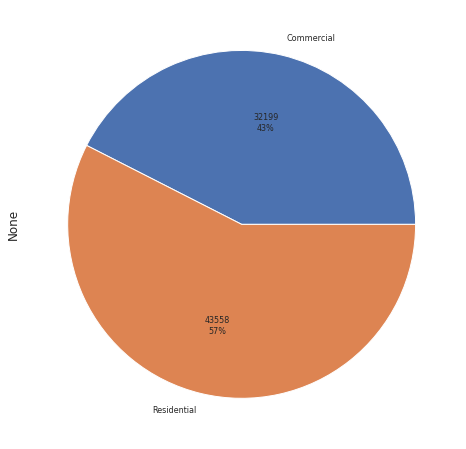

In [21]:
# state factor piechart
def label_function(val):
    return f'{val / 100 * len(train_df):.0f}\n{val:.0f}%'

train_df.groupby('building_class').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8})

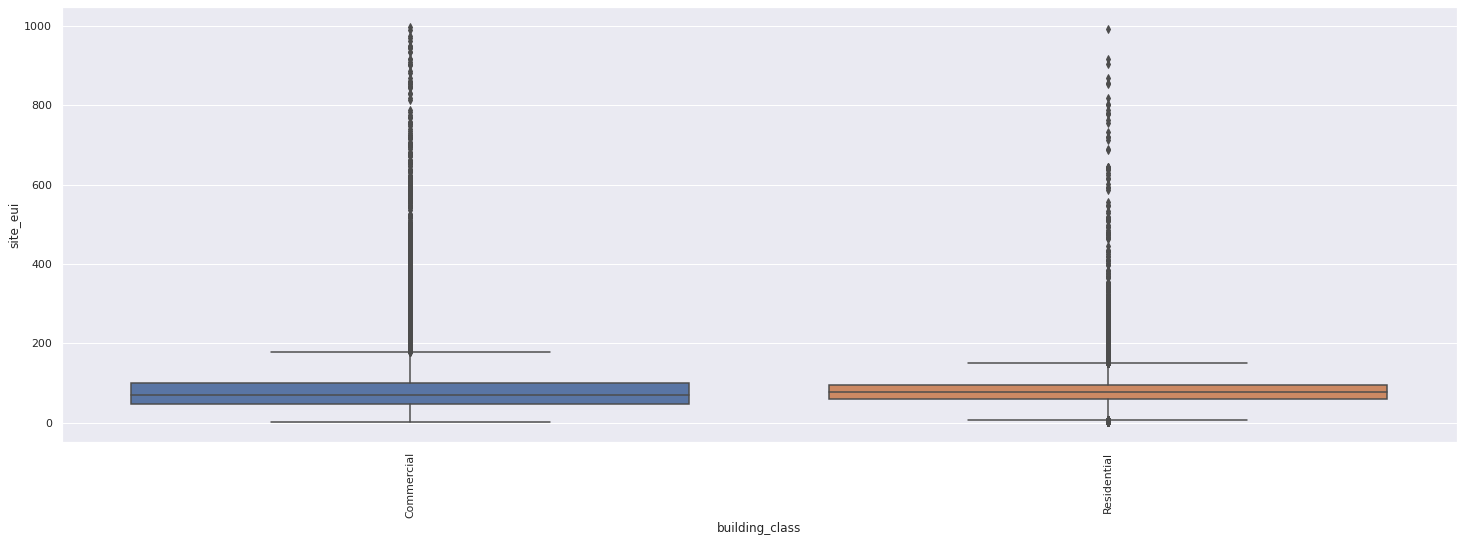

In [22]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='building_class', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

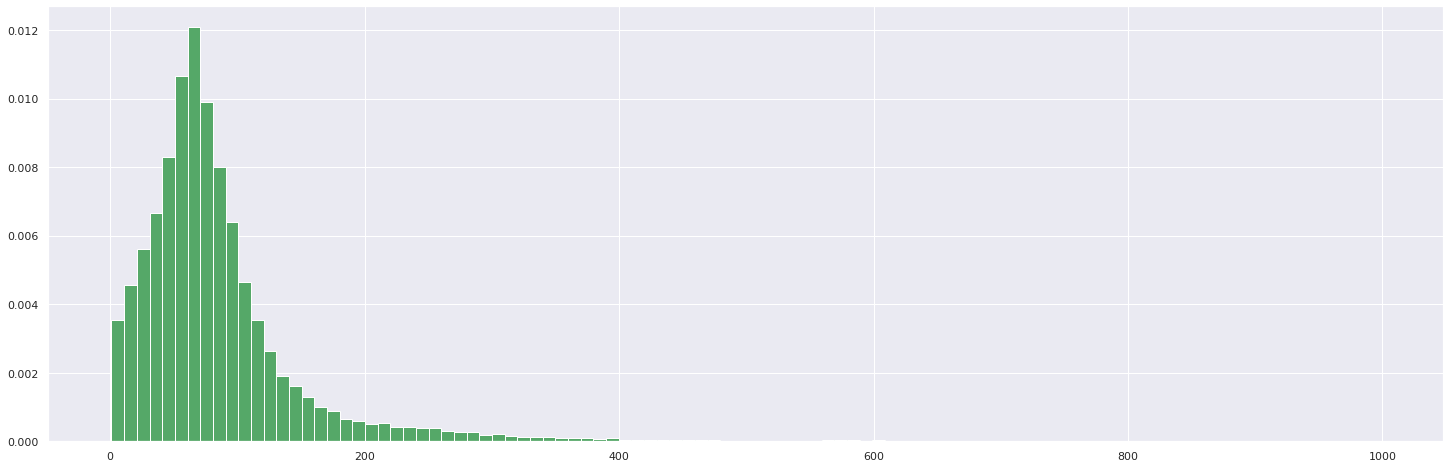

In [23]:
n, bins, patches = plt.hist(train_df.loc[train_df['building_class'] == 'Commercial', 'site_eui'], 100, density=True, facecolor='g')

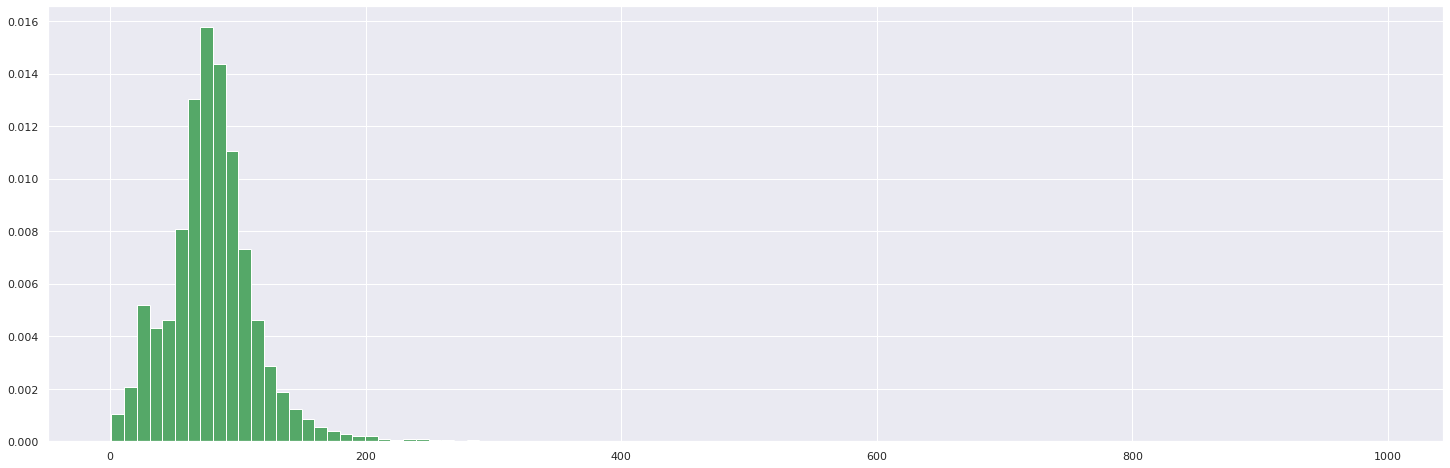

In [24]:
n, bins, patches = plt.hist(train_df.loc[train_df['building_class'] == 'Residential', 'site_eui'], 100, density=True, facecolor='g')

ℹ️  Values over 200 for site_eui correspond mostly to Commercial building class.

## **2.4 Facility Type**

<AxesSubplot:xlabel='facility_type'>

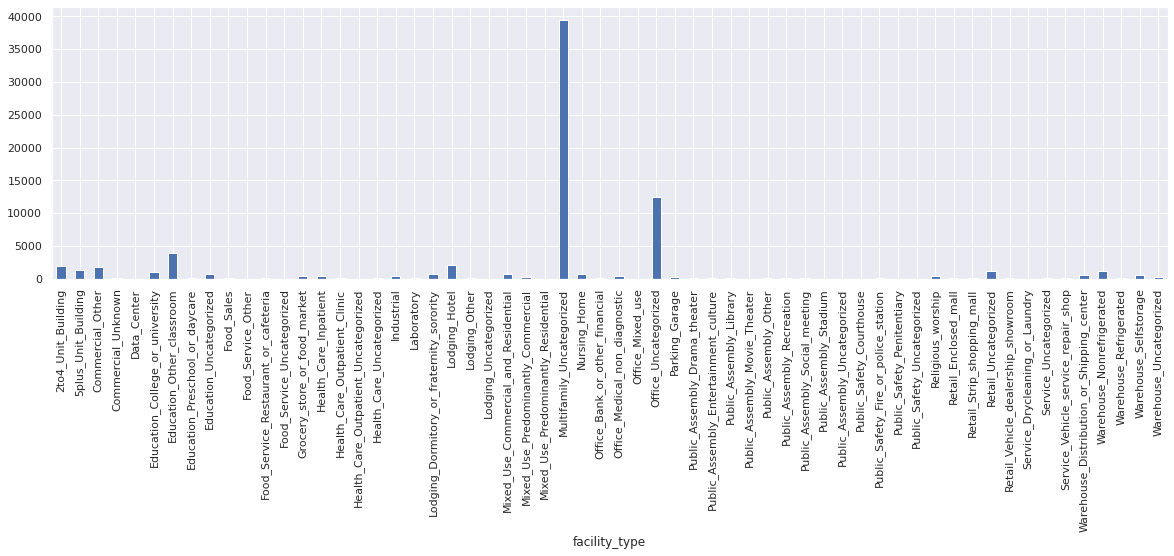

In [25]:
# state factor piechart
def label_function(val):
    return f'{val / 100 * len(train_df):.0f}\n{val:.0f}%'
train_df.groupby('facility_type').size().plot(kind='bar', figsize=(20, 5))

In [26]:
train_facility_type_group = train_df.groupby('facility_type')['id'].count().reset_index()
test_facility_type_group = test_df.groupby('facility_type')['id'].count().reset_index()
train_facility_type_group.rename(columns={'id': 'train_count'}, inplace=True)
test_facility_type_group.rename(columns={'id': 'test_count'}, inplace=True)

facility_type_group = train_facility_type_group.merge(test_facility_type_group, on='facility_type', how='outer')
facility_type_group['ratio'] = facility_type_group['test_count'] / facility_type_group['train_count'] 

In [27]:
facility_type_group

,facility_type,train_count,test_count,ratio
0,2to4_Unit_Building,1893,966,0.510301
1,5plus_Unit_Building,1273,685,0.538099
2,Commercial_Other,1744,325,0.186353
3,Commercial_Unknown,95,23,0.242105
4,Data_Center,27,4,0.148148
5,Education_College_or_university,1056,202,0.191288
6,Education_Other_classroom,3860,890,0.230570
7,Education_Preschool_or_daycare,108,3,0.027778
8,Education_Uncategorized,709,12,0.016925
9,Food_Sales,70,19,0.271429


We have the same facility types in test set as we have in train set.

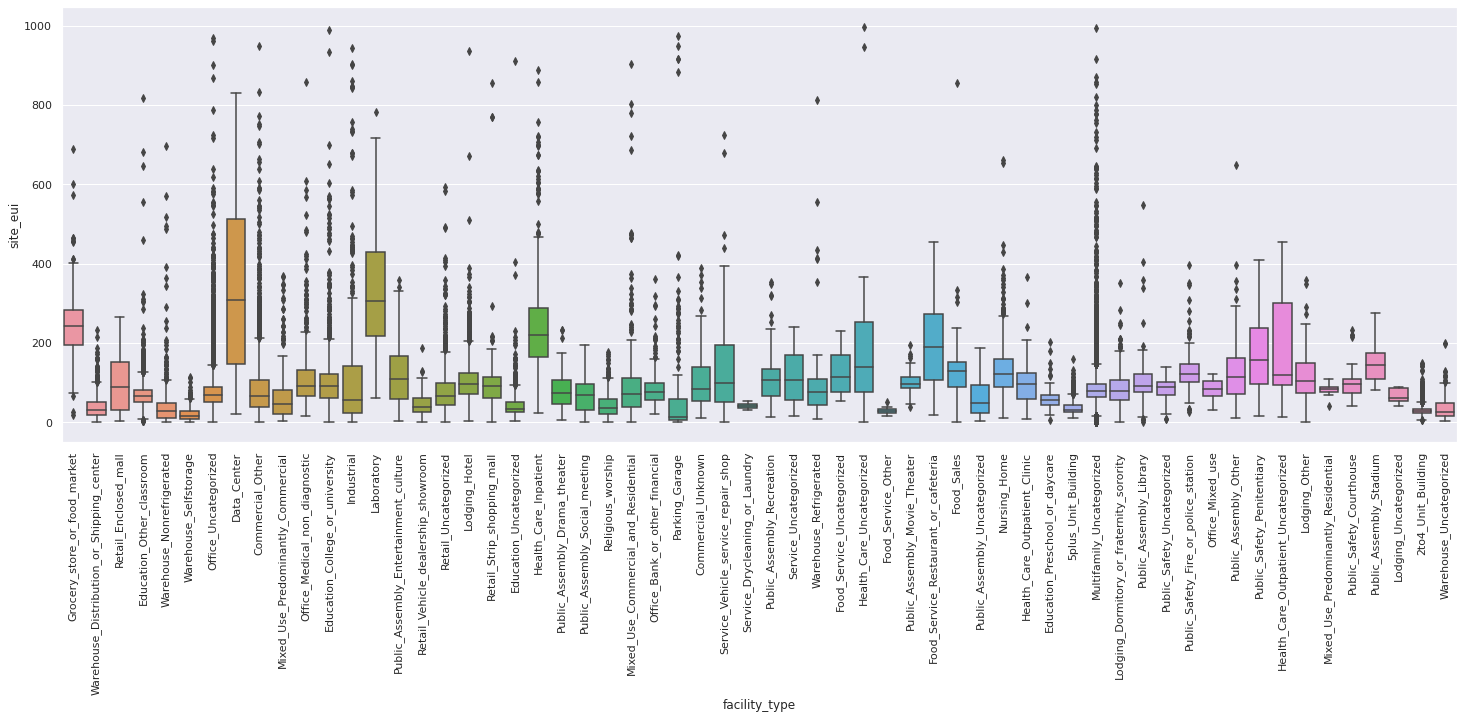

In [28]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='facility_type', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [29]:
def scatter_plot_site_eui_by_facility(df, cat):
    cat_df = df.loc[df['facility_type'].str.startswith(cat)]
    sns.set(rc={'figure.figsize':(25,8)})
    ax = sns.boxplot(data=cat_df, x='facility_type', y='site_eui')
    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [30]:
cat_list = ['Commercial', 'Education', 'Food_Service', 'Health_Care', 'Lodging', 'Office', 'Public_Assembly', 'Public_Safety', 'Retail', 'Service', 'Warehouse']
v = interactive(lambda cat: scatter_plot_site_eui_by_facility(train_df, cat), cat=cat_list)
display(v)

interactive(children=(Dropdown(description='cat', options=('Commercial', 'Education', 'Food_Service', 'Health_…

* The facility types starting with **Commercial** CAN be combined ->
* The facility types starting with **Education** CAN be combined (except for College or University?)
* The facility types starting with **Food Service** CAN NOT be combined
* The facility types starting with **Helth Care** CAN NOT be combined
* The facility types starting with **Lodging** CAN be combined (except for Hotel?)
* The facility types starting with **Office** CAN be combined (except for Uncategorized?)
* The facility types starting with **Public Assembly** 
* The facility types starting with **Public Safety** 
* The facility types starting with **Service** 
* The facility types starting with **Warehouse** CAN be combined (except for Refrigerated?)

In [31]:
def reduce_facility_types(x):
    if x.endswith('Unit_Building'):
        return 'Unit_Building'
    if x.startswith('Commercial'):
        return 'Commercial'
    if x.startswith('Education') and x != 'Education_College_or_university':
        return 'Education_others'
    if x.startswith('Lodging') and x != 'Lodging_Hotel':
        return 'Lodging_others'
    if x.startswith('Office') and x != 'Office_Uncategorized':
        return 'Office_others'
    if x.startswith('Warehouse') and x != 'Warehouse_Refrigerated':
        return 'Warehouse_others'
    if x.startswith('Mixed_Use'):
        return 'Mixed_Use'
    if x.startswith('Health_Care'):
        return 'Health_Care'
    if x.startswith('Public_Assembly'):
        return 'Public_Assembly'
    return x

In [32]:
train_df['facility_type_reduced'] = [ reduce_facility_types(x) for x in train_df['facility_type']]

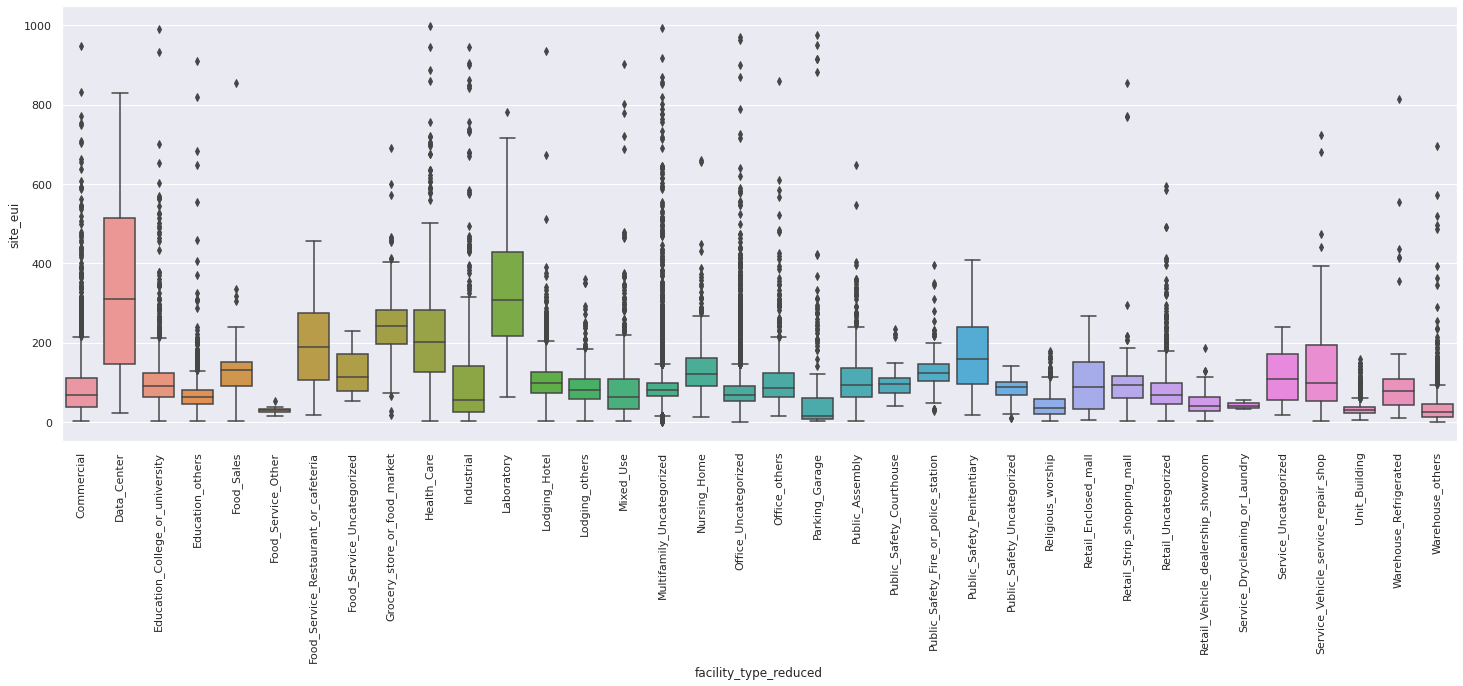

In [33]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='facility_type_reduced', y='site_eui', order=sorted(list(set(train_df['facility_type_reduced']))))
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [34]:
train_df.groupby('facility_type_reduced')['id'].count().reset_index().sort_values('id', ascending=False).head(100)

,facility_type_reduced,id
15,Multifamily_Uncategorized,39455
17,Office_Uncategorized,12512
3,Education_others,4677
33,Unit_Building,3166
35,Warehouse_others,2766
12,Lodging_Hotel,2098
0,Commercial,1839
28,Retail_Uncategorized,1130
2,Education_College_or_university,1056
14,Mixed_Use,937


ℹ️ Some of the **facility types show a greater site_eui** than the other categories: <br>
* **Grocery_store_or_food_market**
* **Data_Center**
* **Laboratory**
* **Health_Care_Impatient**

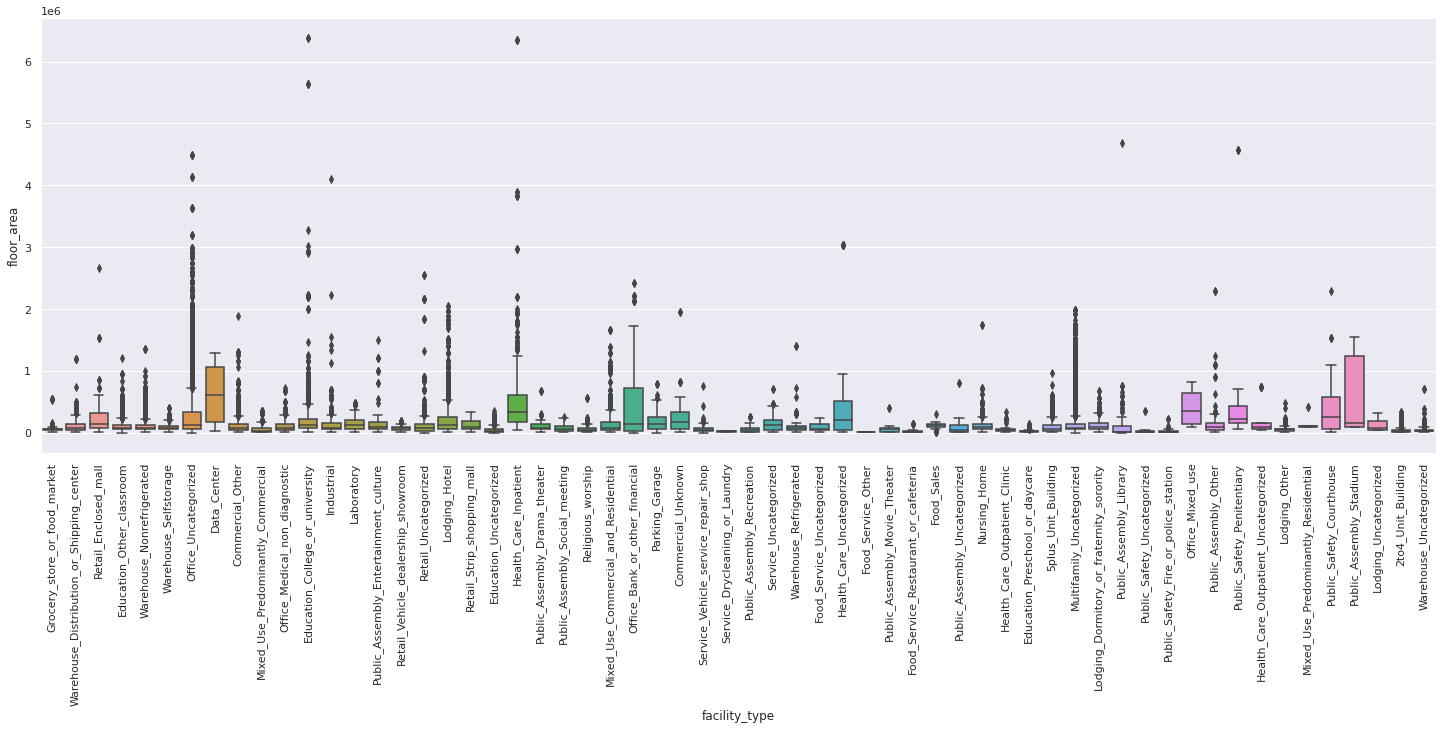

In [35]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='facility_type', y='floor_area')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

ℹ️ There are some facility types which have greater floor area.

In [36]:
facility_type_df = train_df.groupby(['facility_type'])['building_class'].apply(set)

In [37]:
facility_type_df.head(100)

facility_type
2to4_Unit_Building                           {Residential}
5plus_Unit_Building                          {Residential}
Commercial_Other                              {Commercial}
Commercial_Unknown                            {Commercial}
Data_Center                                   {Commercial}
Education_College_or_university               {Commercial}
Education_Other_classroom                     {Commercial}
Education_Preschool_or_daycare                {Commercial}
Education_Uncategorized                       {Commercial}
Food_Sales                                    {Commercial}
Food_Service_Other                            {Commercial}
Food_Service_Restaurant_or_cafeteria          {Commercial}
Food_Service_Uncategorized                    {Commercial}
Grocery_store_or_food_market                  {Commercial}
Health_Care_Inpatient                         {Commercial}
Health_Care_Outpatient_Clinic                 {Commercial}
Health_Care_Outpatient_Uncategorized      

ℹ️ The facility type is a more stratified version of building type, so only one of them should be used.

## **2.5 Floor area**

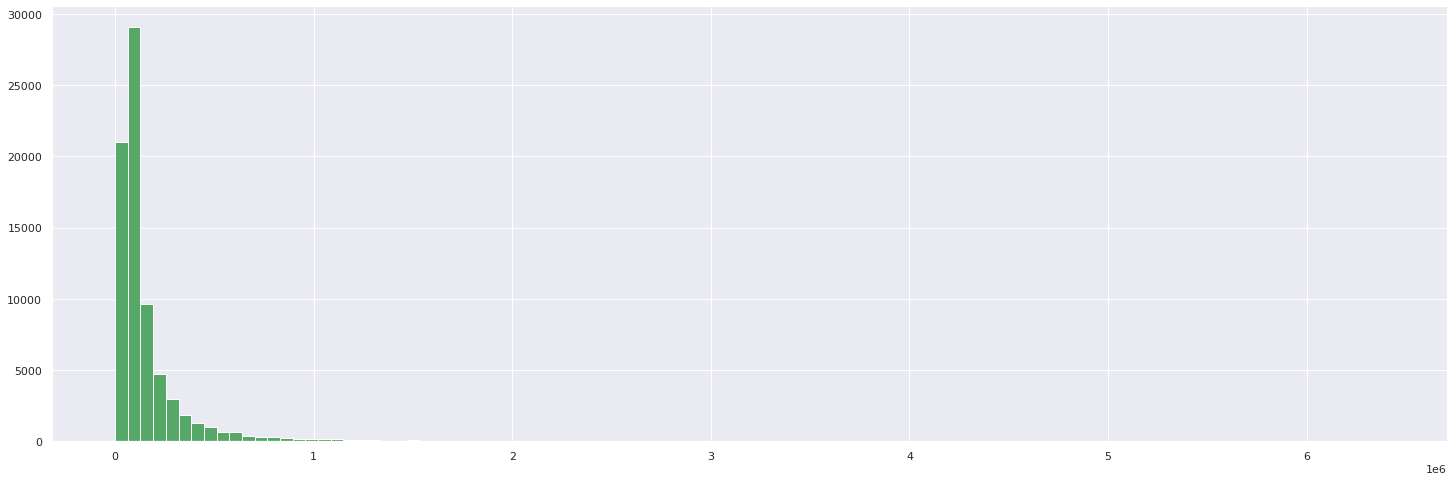

In [38]:
# histogram of floor area
n, bins, patches = plt.hist(train_df['floor_area'], 100, density=False, facecolor='g')

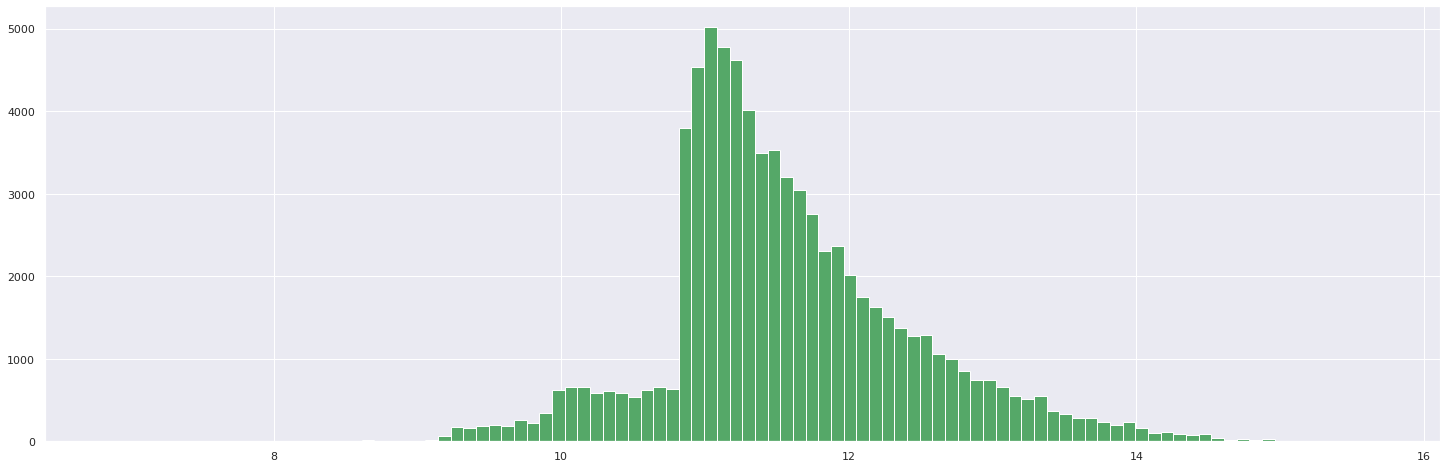

In [39]:
# histogram of log of floor area
n, bins, patches = plt.hist(np.log(train_df['floor_area']), 100, density=False, facecolor='g')

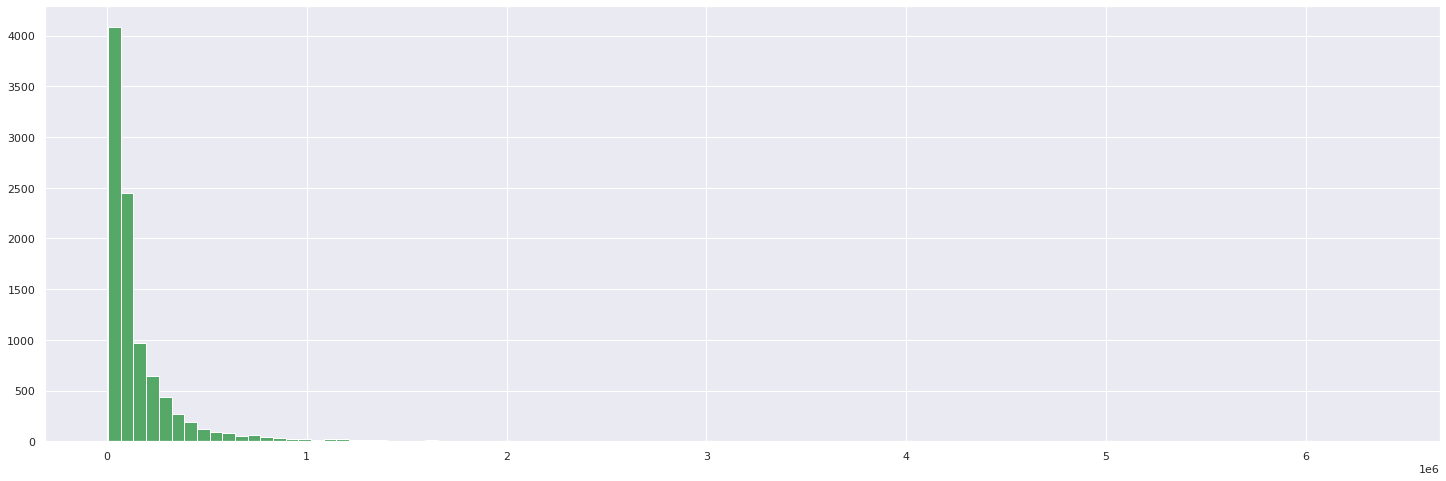

In [40]:
n, bins, patches = plt.hist(test_df['floor_area'], 100, density=False, facecolor='g')

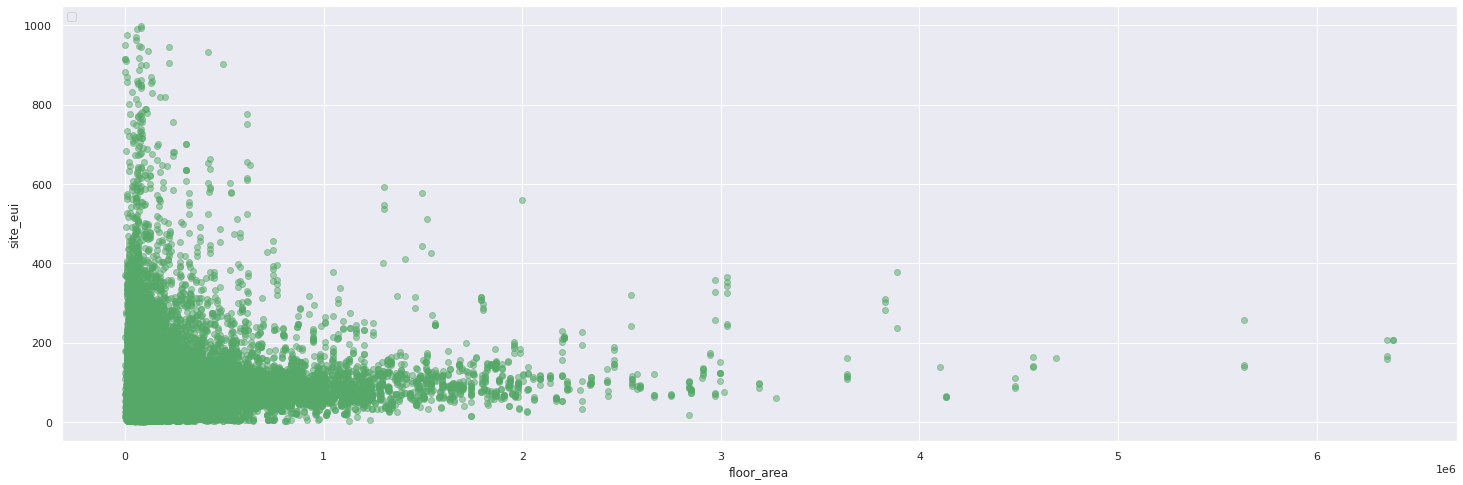

In [41]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df['floor_area'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel("floor_area")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

## **2.6 Year built**

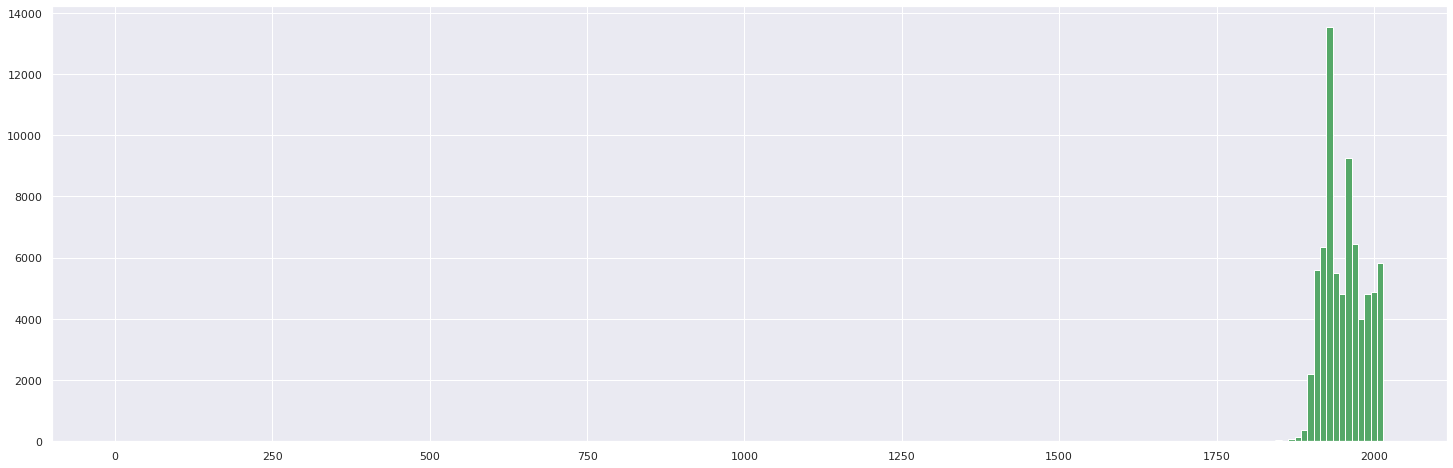

In [42]:
# histogram of year built
n, bins, patches = plt.hist(train_df['year_built'], 200, density=False, facecolor='g')

In [43]:
print(train_df.loc[train_df['year_built'] < 1600])

      Year_Factor State_Factor building_class  facility_type  floor_area  \
353             1      State_1     Commercial  Lodging_Hotel    204392.0   
955             2      State_1     Commercial  Lodging_Hotel    204392.0   
2159            3      State_1     Commercial  Lodging_Hotel    204392.0   
3415            4      State_1     Commercial  Lodging_Hotel    204392.0   
4535            5      State_1     Commercial  Lodging_Hotel    204392.0   
5571            6      State_1     Commercial  Lodging_Hotel    204392.0   

      year_built  energy_star_rating  ELEVATION  january_min_temp  \
353          0.0                61.0       59.1                36   
955          0.0                63.0        2.4                27   
2159         0.0                63.0        9.1                22   
3415         0.0                68.0        9.1                41   
4535         0.0                76.0        9.1                29   
5571         0.0                78.0       45.7      

 💡 **Idea** <br>
There are 6 records corresponding to a building which is said to be built in **year 0**. Infer another value for year 0 because it might affect normalization.

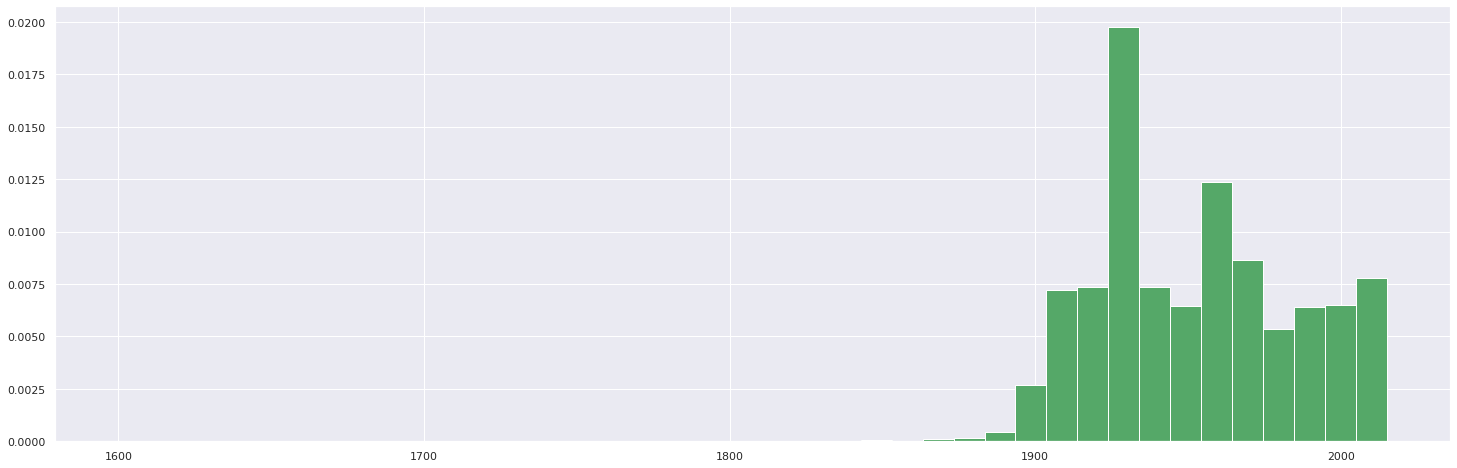

In [44]:
n, bins, patches = plt.hist(train_df.loc[train_df['year_built'] >= 1600, 'year_built'], (2015 - 1600)//10, density=True, facecolor='g')

ℹ️ Most of the buildings where built after 1900.

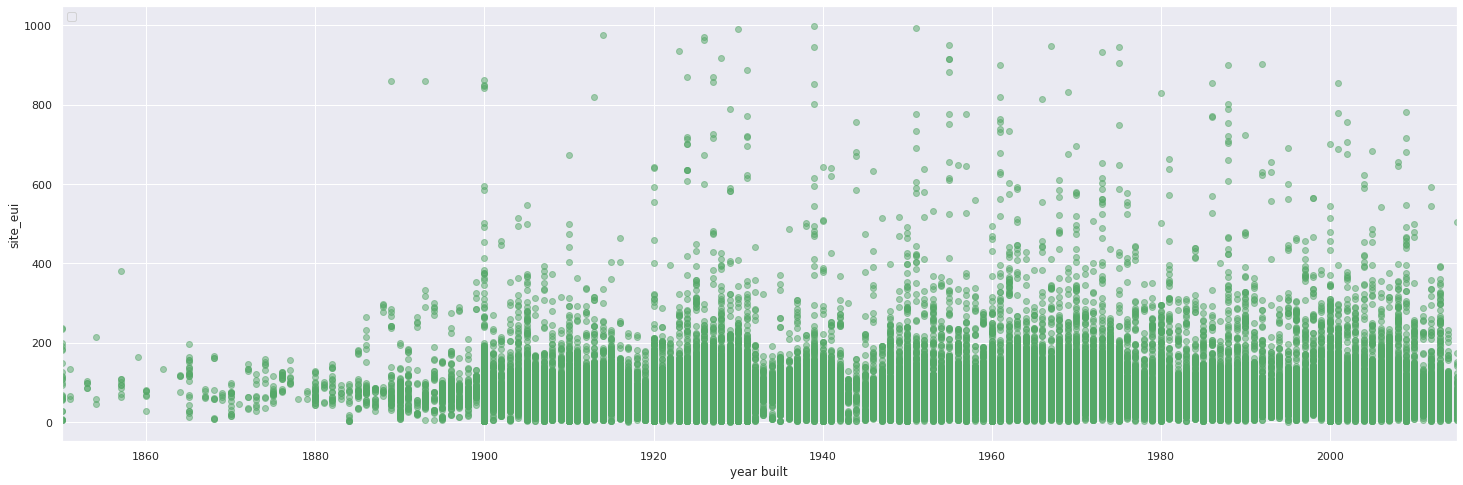

In [45]:
# scatter plot to see correlation between year built and site_eui
plt.scatter(train_df['year_built'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel("year built")
plt.ylabel("site_eui")
plt.xlim(1850, 2015)
plt.legend(loc='upper left')
plt.show()

ℹ️ There seems to be no evident correlation between the year built and the site_eui. Compute something like a matrix with histograms (for each year built and normalized by year).

## **2.7 Energy Star Rating**

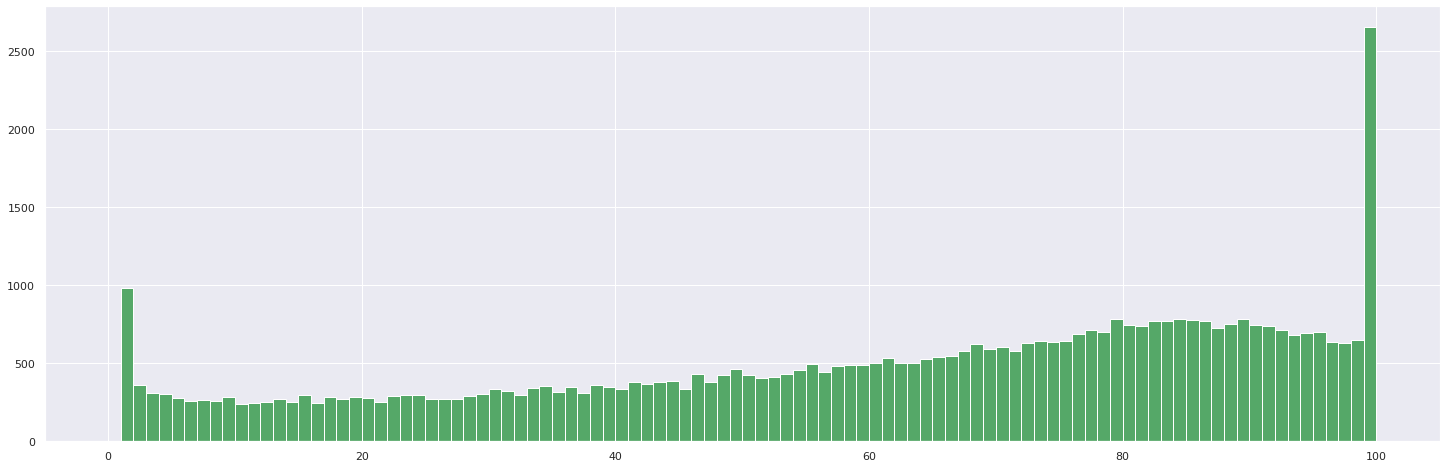

In [46]:
n, bins, patches = plt.hist(train_df['energy_star_rating'], 100, density=False, facecolor='g')

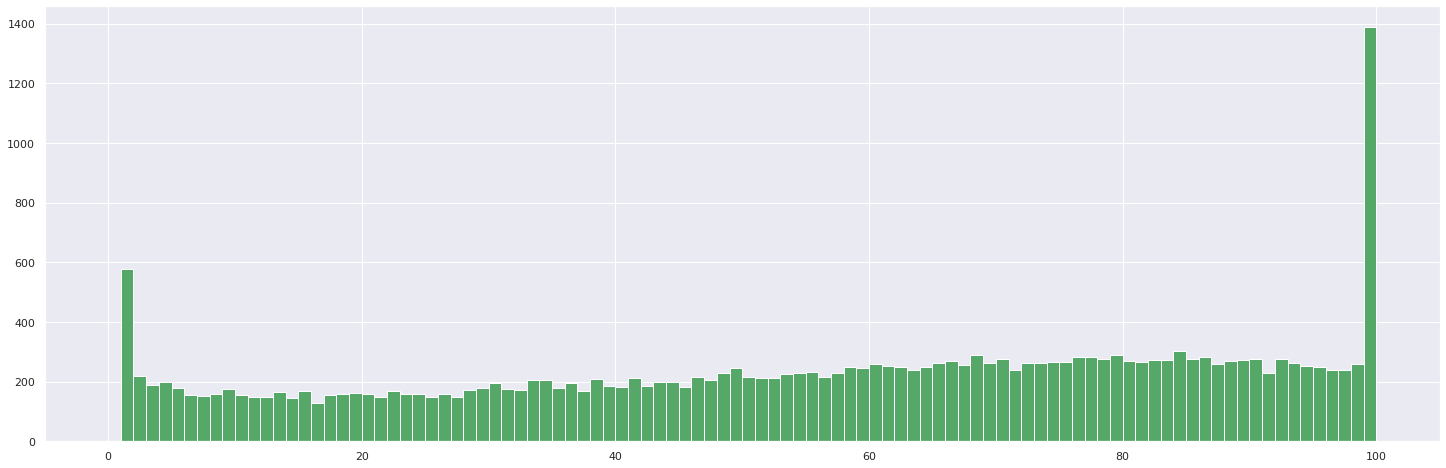

In [47]:
cat_df = train_df.loc[train_df['facility_type'] == 'Multifamily_Uncategorized']
n, bins, patches = plt.hist(cat_df['energy_star_rating'], 100, range=(0, 100), density=False, facecolor='g')

7.516129032258065


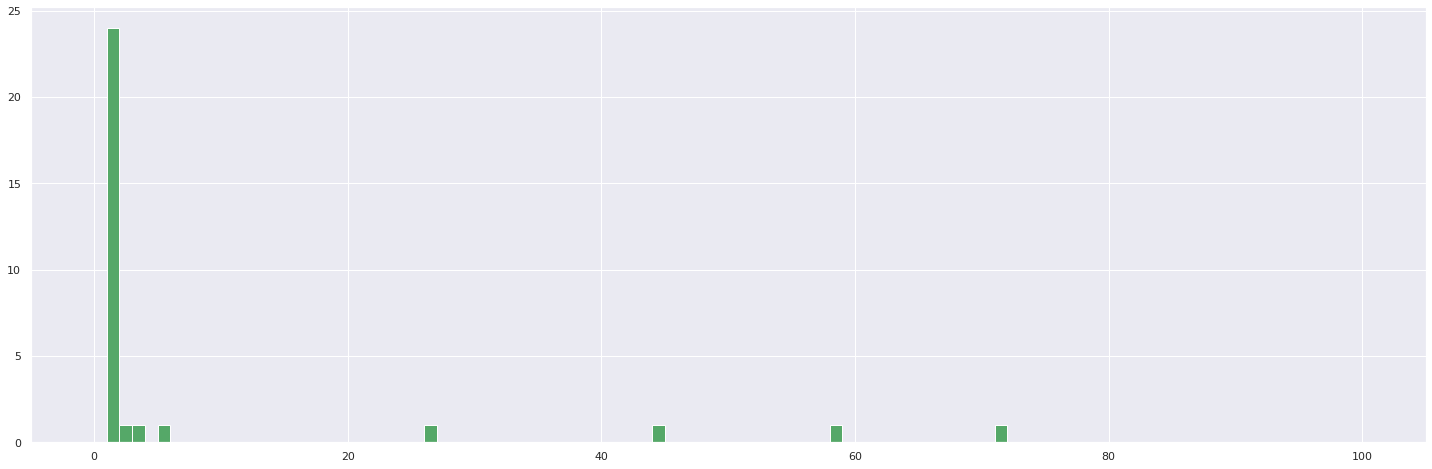

In [48]:
cat_df = train_df.loc[(train_df['facility_type'] == 'Multifamily_Uncategorized') & (train_df['site_eui'] > 400)]
n, bins, patches = plt.hist(cat_df['energy_star_rating'], 100, range=(0, 100), density=False, facecolor='g')
print(np.mean(cat_df['energy_star_rating']))

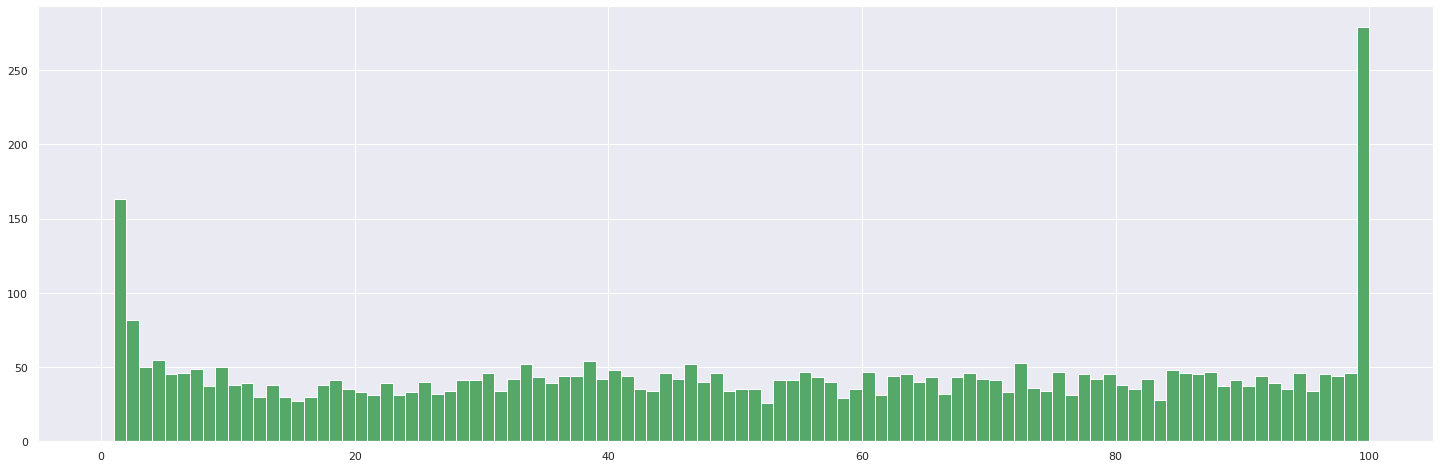

In [49]:
cat_df = train_df.loc[(train_df['facility_type'] == 'Multifamily_Uncategorized') & (train_df['year_built'] > 1980)]
n, bins, patches = plt.hist(cat_df['energy_star_rating'], 100, range=(0, 100), density=False, facecolor='g')

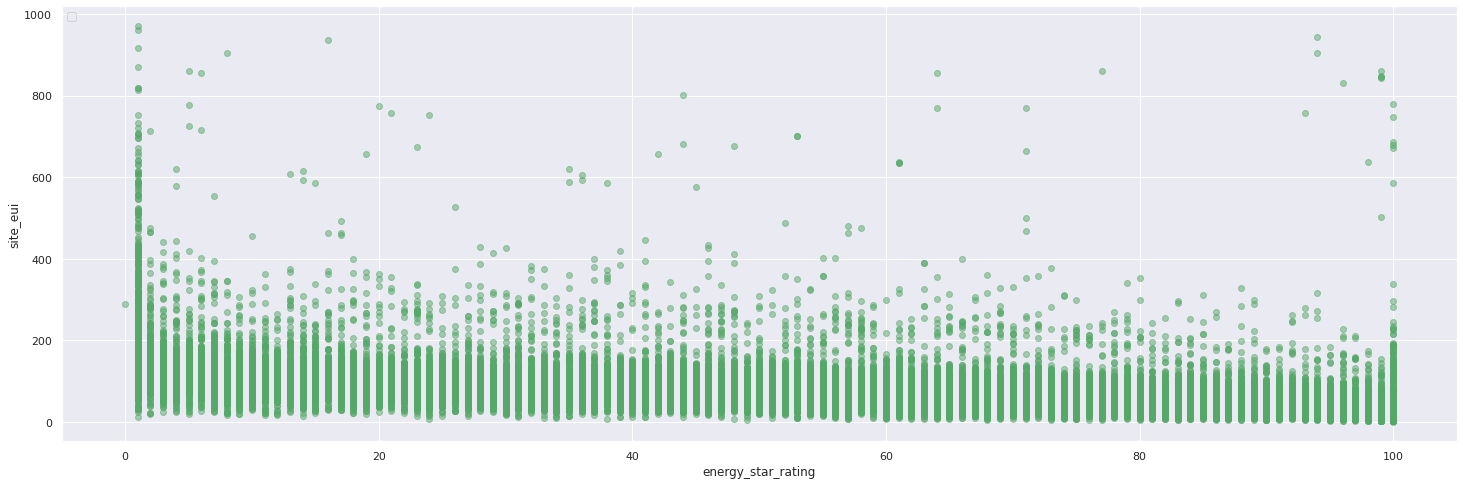

In [50]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df['energy_star_rating'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel("energy_star_rating")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

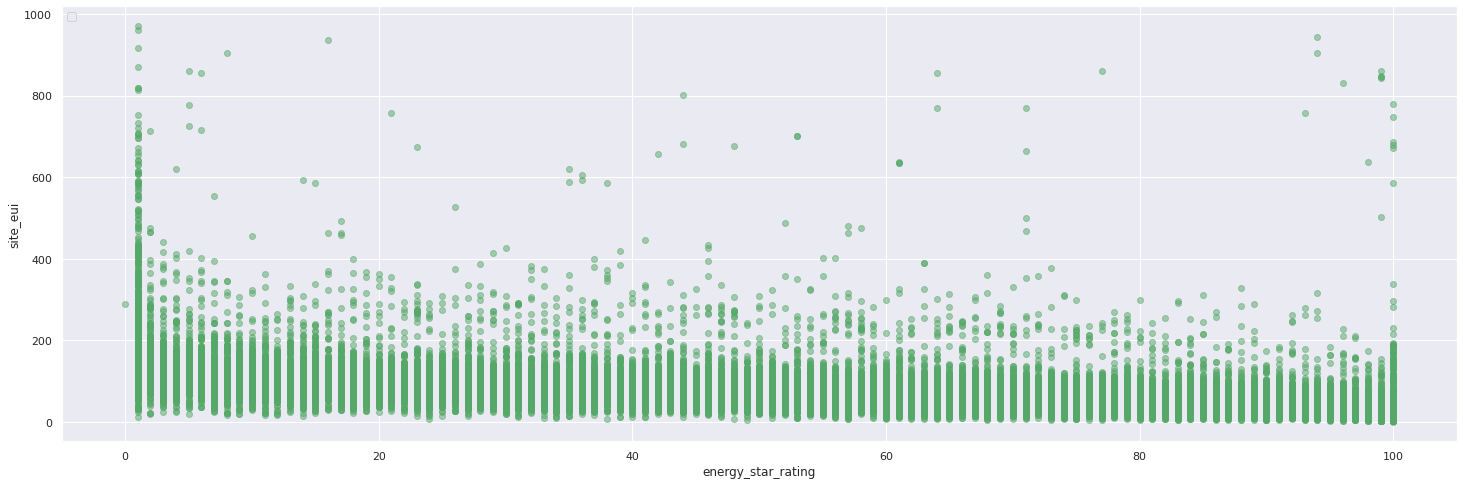

In [51]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df.loc[train_df['floor_area'] < 0.5 * 1000000, 'energy_star_rating'], train_df.loc[train_df['floor_area'] < 0.5 * 1000000, 'site_eui'], c="g", alpha=0.5)
plt.xlabel("energy_star_rating")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

❓ Why do we have buildings with an energy star rating of 100 and a great site_eui?

In [52]:
train_df.loc[(train_df['energy_star_rating'] > 90) & (train_df['site_eui'] > 400)]

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,facility_type_reduced
14842,1,State_6,Commercial,Data_Center,66080.0,1980.0,99.0,3.4,6,29.677419,...,16,1,0,1.0,1.0,1.0,12.0,502.542373,14842,Data_Center
65650,3,State_8,Commercial,Industrial,220000.0,1975.0,94.0,3.0,4,32.903226,...,16,0,0,350.0,360.0,18.3,65.0,904.544309,65650,Industrial
65691,3,State_8,Commercial,Industrial,80064.0,1900.0,99.0,3.0,4,32.903226,...,16,0,0,350.0,360.0,18.3,65.0,849.465483,65691,Industrial
66100,3,State_8,Commercial,Industrial,240000.0,1944.0,93.0,3.0,4,32.903226,...,16,0,0,350.0,360.0,18.3,65.0,757.424281,66100,Industrial
66463,4,State_8,Commercial,Industrial,220000.0,1975.0,94.0,3.0,3,29.258065,...,20,0,0,1.0,1.0,1.0,NaN,944.895706,66463,Industrial
66506,4,State_8,Commercial,Industrial,80064.0,1900.0,99.0,3.0,3,29.258065,...,20,0,0,1.0,1.0,1.0,NaN,846.844634,66506,Industrial
66913,4,State_8,Commercial,Industrial,240000.0,1944.0,100.0,12.2,3,29.258065,...,20,0,0,NaN,NaN,NaN,NaN,671.408443,66913,Industrial
67344,5,State_8,Commercial,Industrial,80064.0,1900.0,99.0,291.4,2,26.516129,...,15,0,0,NaN,NaN,NaN,NaN,861.505083,67344,Industrial
67797,5,State_8,Commercial,Industrial,240000.0,1944.0,100.0,114.3,3,24.016129,...,6,0,0,NaN,NaN,NaN,NaN,680.239127,67797,Industrial
68253,6,State_8,Commercial,Industrial,80064.0,1900.0,99.0,3.0,8,29.827586,...,21,0,0,1.0,1.0,1.0,116.0,843.117233,68253,Industrial


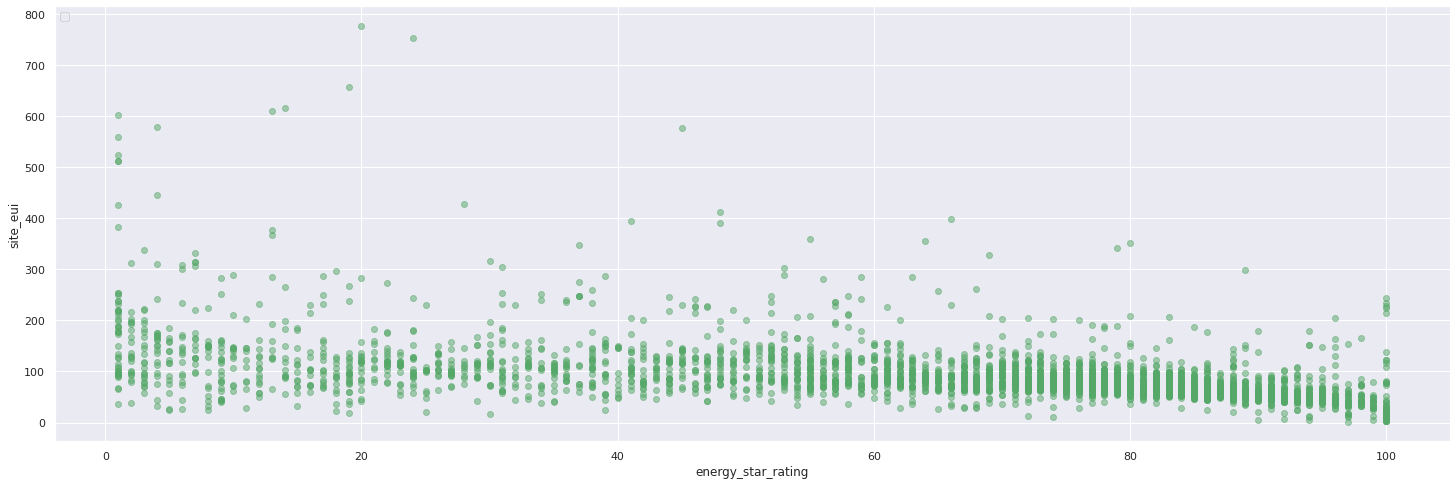

In [53]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df.loc[train_df['floor_area'] > 0.5 * 1000000, 'energy_star_rating'], train_df.loc[train_df['floor_area'] > 0.5 * 1000000, 'site_eui'], c="g", alpha=0.5)
plt.xlabel("energy_star_rating")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

ℹ️ The site_eui shows a correlation with the energy_star_rating (the site_eui decreases as the energy_star_rating increases).

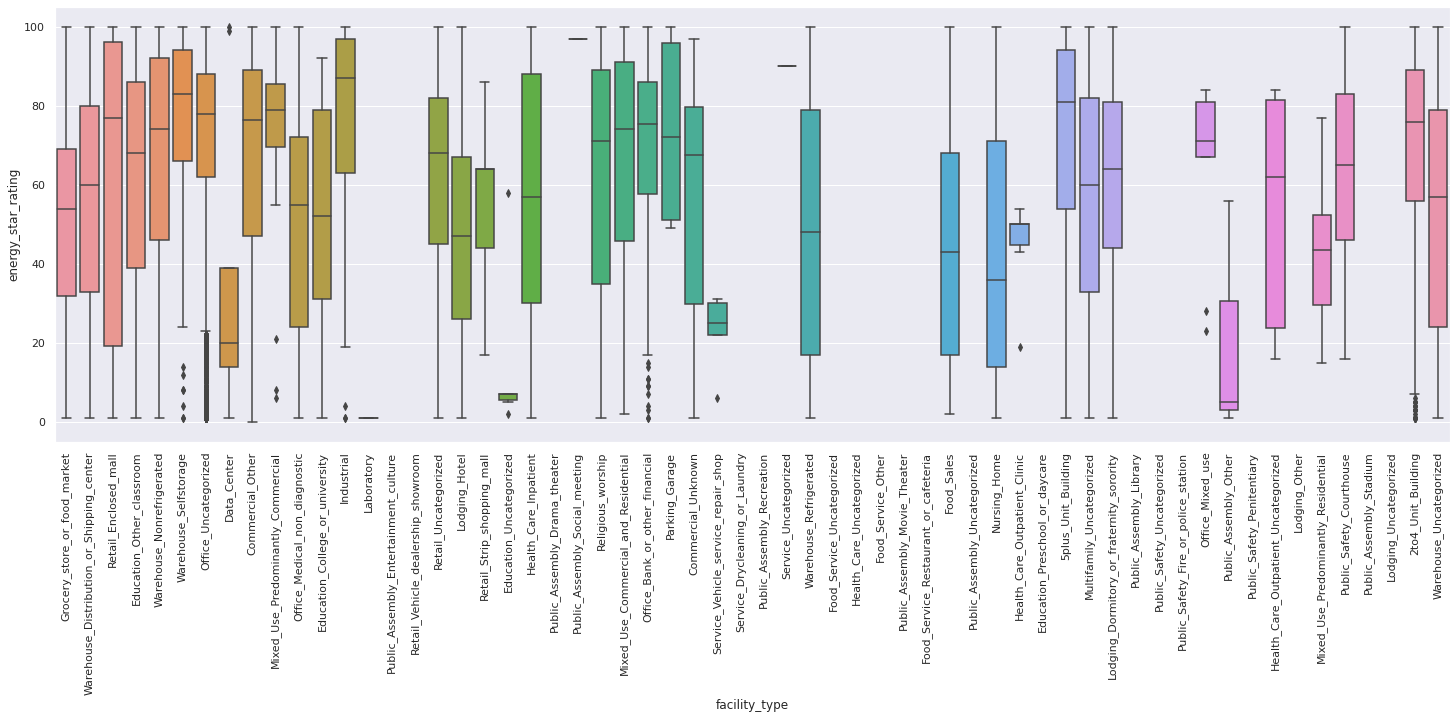

In [54]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='facility_type', y='energy_star_rating')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

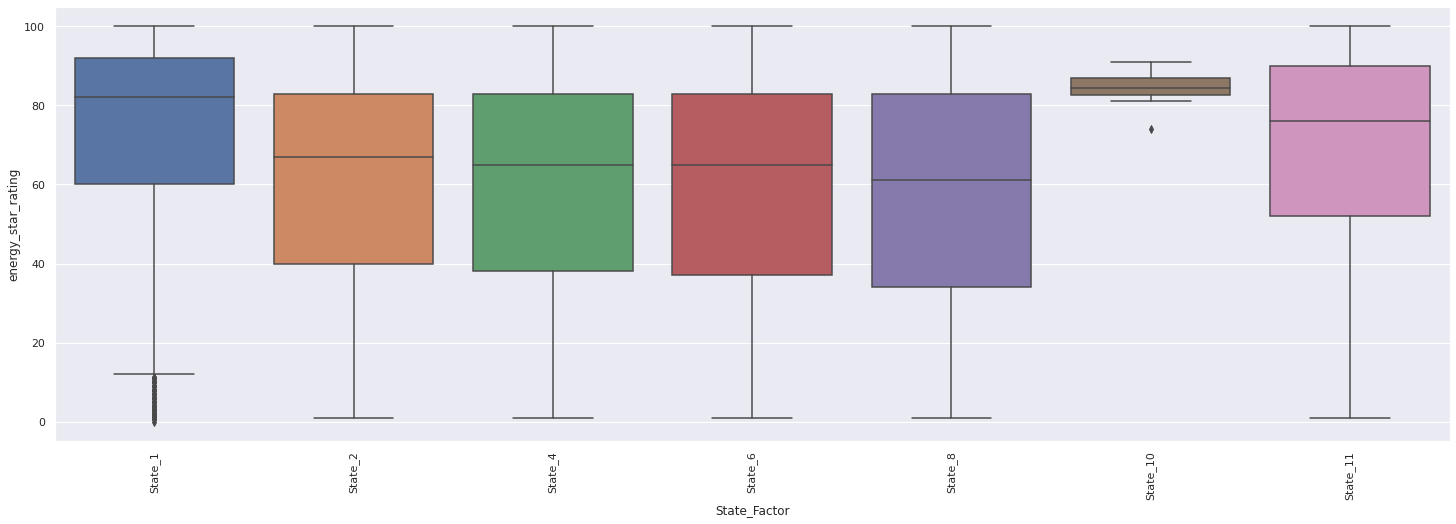

In [55]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='State_Factor', y='energy_star_rating')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

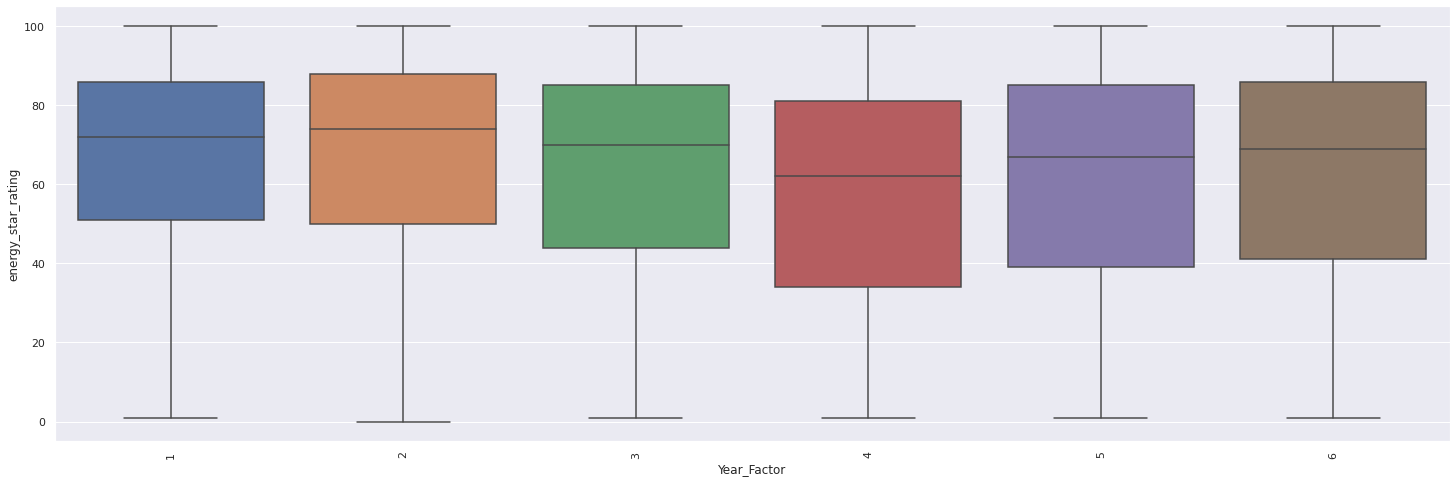

In [56]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='Year_Factor', y='energy_star_rating')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

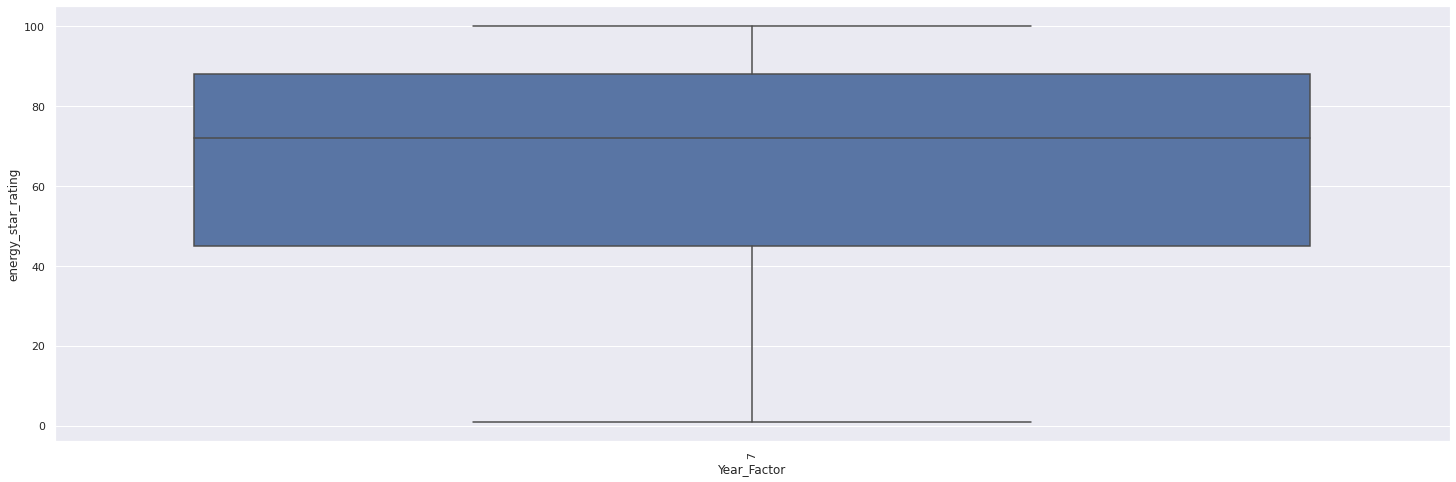

In [57]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=test_df, x='Year_Factor', y='energy_star_rating')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

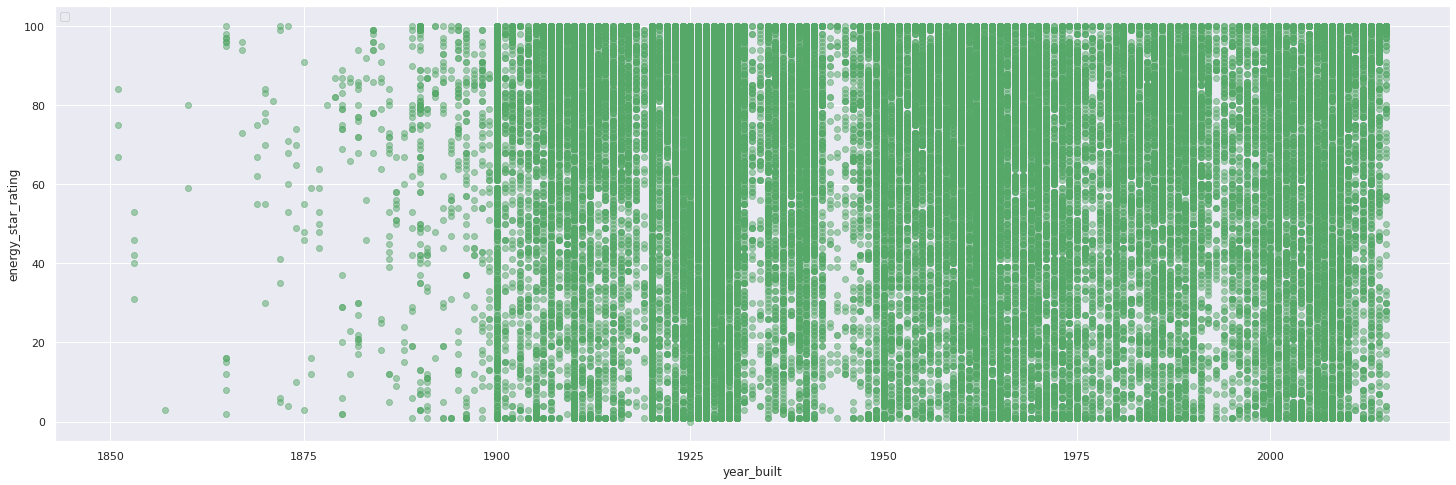

In [58]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df.loc[train_df['year_built'] > 1850, 'year_built'], train_df.loc[train_df['year_built'] > 1850, 'energy_star_rating'], c="g", alpha=0.5)
plt.xlabel("year_built")
plt.ylabel("energy_star_rating")
plt.legend(loc='upper left')
plt.show()

In [59]:
x = train_df.loc[(train_df['year_built'] > 1850) & (train_df['energy_star_rating'].notnull()), 'year_built']
y = train_df.loc[(train_df['year_built'] > 1850) & (train_df['energy_star_rating'].notnull()), 'energy_star_rating']

In [60]:
np.corrcoef(x, y)

array([[ 1.        , -0.08845305],
       [-0.08845305,  1.        ]])

There is no correlation between the year built and the energy star rating.

In [61]:
null_counts_df = train_df.groupby(['facility_type'])['energy_star_rating'].apply(lambda x: x.isnull().sum()).reset_index()
not_null_counts_df = train_df.groupby(['facility_type'])['energy_star_rating'].apply(lambda x: x.notnull().sum()).reset_index()
merge_df = null_counts_df.merge(not_null_counts_df, on='facility_type')
merge_df.rename({'energy_star_rating_x': 'null', 'energy_star_rating_y': 'not_null'}, axis=1, inplace=True)
merge_df['null_percentage'] = merge_df['null'] / (merge_df['null'] + merge_df['not_null'])
merge_df.sort_values(['null_percentage'], ascending=False)

,facility_type,null,not_null,null_percentage
51,Retail_Vehicle_dealership_showroom,74,0,1.000000
41,Public_Assembly_Stadium,9,0,1.000000
23,Lodging_Uncategorized,5,0,1.000000
17,Health_Care_Uncategorized,51,0,1.000000
36,Public_Assembly_Library,160,0,1.000000
42,Public_Assembly_Uncategorized,25,0,1.000000
44,Public_Safety_Fire_or_police_station,157,0,1.000000
45,Public_Safety_Penitentiary,37,0,1.000000
12,Food_Service_Uncategorized,18,0,1.000000
11,Food_Service_Restaurant_or_cafeteria,64,0,1.000000


In [62]:
sum(merge_df['null'])

26709

In [63]:
null_counts_df = train_df.groupby(['State_Factor'])['energy_star_rating'].apply(lambda x: x.isnull().sum()).reset_index()
not_null_counts_df = train_df.groupby(['State_Factor'])['energy_star_rating'].apply(lambda x: x.notnull().sum()).reset_index()
merge_df = null_counts_df.merge(not_null_counts_df, on='State_Factor')
merge_df.rename({'energy_star_rating_x': 'null', 'energy_star_rating_y': 'not_null'}, axis=1, inplace=True)
merge_df['null_percentage'] = merge_df['null'] / (merge_df['null'] + merge_df['not_null'])
merge_df.sort_values(['null_percentage'], ascending=False)

,State_Factor,null,not_null,null_percentage
5,State_6,20153,30687,0.396400
0,State_1,2069,3549,0.368281
6,State_8,1252,2449,0.338287
2,State_11,1517,4895,0.236588
3,State_2,1011,3860,0.207555
1,State_10,3,12,0.200000
4,State_4,704,3596,0.163721


In [64]:
null_counts_df = train_df.groupby(['Year_Factor'])['energy_star_rating'].apply(lambda x: x.isnull().sum()).reset_index()
not_null_counts_df = train_df.groupby(['Year_Factor'])['energy_star_rating'].apply(lambda x: x.notnull().sum()).reset_index()
merge_df = null_counts_df.merge(not_null_counts_df, on='Year_Factor')
merge_df.rename({'energy_star_rating_x': 'null', 'energy_star_rating_y': 'not_null'}, axis=1, inplace=True)
merge_df['null_percentage'] = merge_df['null'] / (merge_df['null'] + merge_df['not_null'])
merge_df.sort_values(['null_percentage'], ascending=False)

,Year_Factor,null,not_null,null_percentage
1,2,7154,1904,0.789799
2,3,8056,2823,0.740509
0,1,590,1527,0.278696
3,4,2880,10066,0.222463
5,6,4487,17962,0.199875
4,5,3542,14766,0.193467


## **2.8 Elevation**

❓ Is it correct that the elevation changes throught the years for the same building?

In [65]:
elevation_df = train_df.groupby(['State_Factor', 'building_class', 'facility_type', 'floor_area'])['ELEVATION'].apply(list).reset_index()

In [66]:
elevation_df.head(100)

,State_Factor,building_class,facility_type,floor_area,ELEVATION
0,State_1,Commercial,Commercial_Other,10149.0,"[45.7, 120.4, 59.1]"
1,State_1,Commercial,Commercial_Other,10755.0,"[9.1, 9.1, 9.1, 45.7]"
2,State_1,Commercial,Commercial_Other,11446.0,"[9.1, 9.1, 9.1, 45.7]"
3,State_1,Commercial,Commercial_Other,11730.0,"[15.8, 15.8, 2.4]"
4,State_1,Commercial,Commercial_Other,13000.0,"[120.4, 59.1]"
...,...,...,...,...,...
95,State_1,Commercial,Education_Other_classroom,32654.0,"[9.1, 9.1]"
96,State_1,Commercial,Education_Other_classroom,33000.0,"[9.1, 9.1, 9.1, 45.7]"
97,State_1,Commercial,Education_Other_classroom,35072.0,"[45.7, 15.8, 2.4]"
98,State_1,Commercial,Education_Other_classroom,41000.0,"[18.6, 52.7, 43.9, 9.1]"


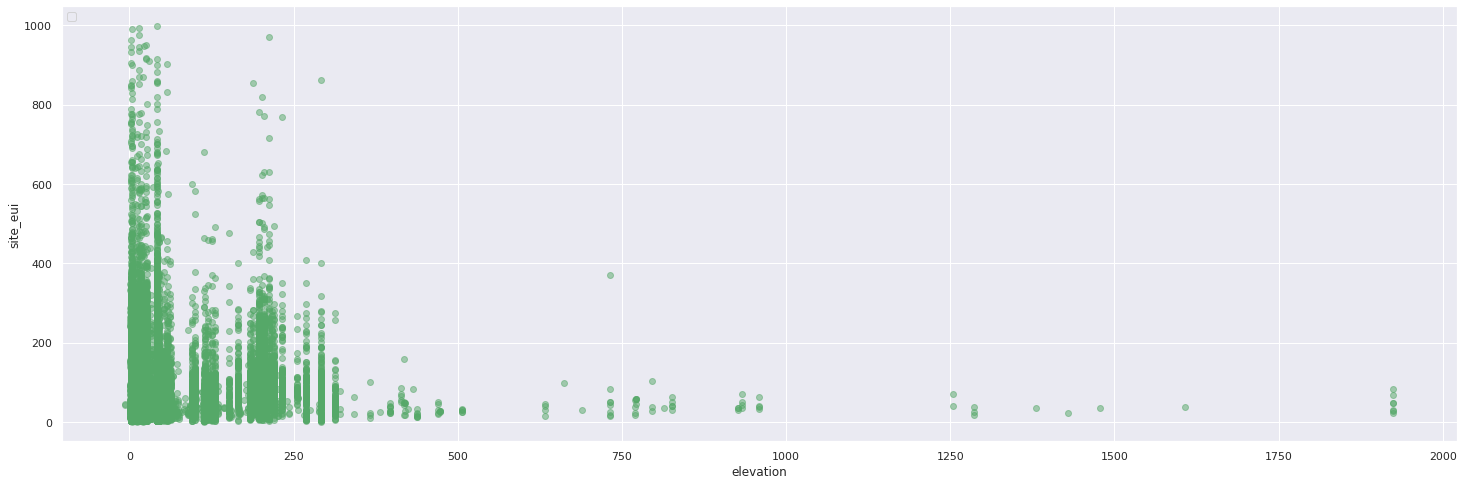

In [67]:
# scatter plot to see correlation between elevation and site_eui
plt.scatter(train_df['ELEVATION'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel("elevation")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

## **2.9 Temperature**

In [68]:
def box_plot_temperatures_by_state(df, p_month, p_stat):
    sns.set(rc={'figure.figsize':(25,8)})
    ax = sns.boxplot(data=df, x='State_Factor', y=f'{p_month}_{p_stat}_temp')
    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [69]:
months_list = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
v = interactive(lambda month, stat: box_plot_temperatures_by_state(train_df, month, stat), month=months_list, stat=['min', 'avg', 'max'])
display(v)

interactive(children=(Dropdown(description='month', options=('january', 'february', 'march', 'april', 'may', '…

ℹ️ The relationship between states is the same throughout months for the min statistic. <br>

In [70]:
def scatter_plot_site_eui_by_temperatures(df, p_month, p_stat):
    plt.scatter(train_df[f'{p_month}_{p_stat}_temp'], train_df['site_eui'], c="g", alpha=0.5)
    plt.xlabel(f'{p_month}_{p_stat}_temp')
    plt.ylabel("site_eui")
    plt.legend(loc='upper left')
    plt.show()

In [71]:
months_list = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
v = interactive(lambda month, stat: scatter_plot_site_eui_by_temperatures(train_df, month, stat), month=months_list, stat=['min', 'avg', 'max'])
display(v)

interactive(children=(Dropdown(description='month', options=('january', 'february', 'march', 'april', 'may', '…

ℹ️ No direct correlation between temperatures and site_eui.

## **2.10 Cooling/Heating degree days**

In [72]:
train_df[['cooling_degree_days', 'heating_degree_days']].describe()

,cooling_degree_days,heating_degree_days
count,75757.000000,75757.000000
mean,1202.250446,4324.957390
std,391.561780,824.366727
min,0.000000,398.000000
25%,1128.000000,3978.000000
50%,1277.000000,4337.000000
75%,1489.000000,4670.000000
max,4948.000000,7929.000000


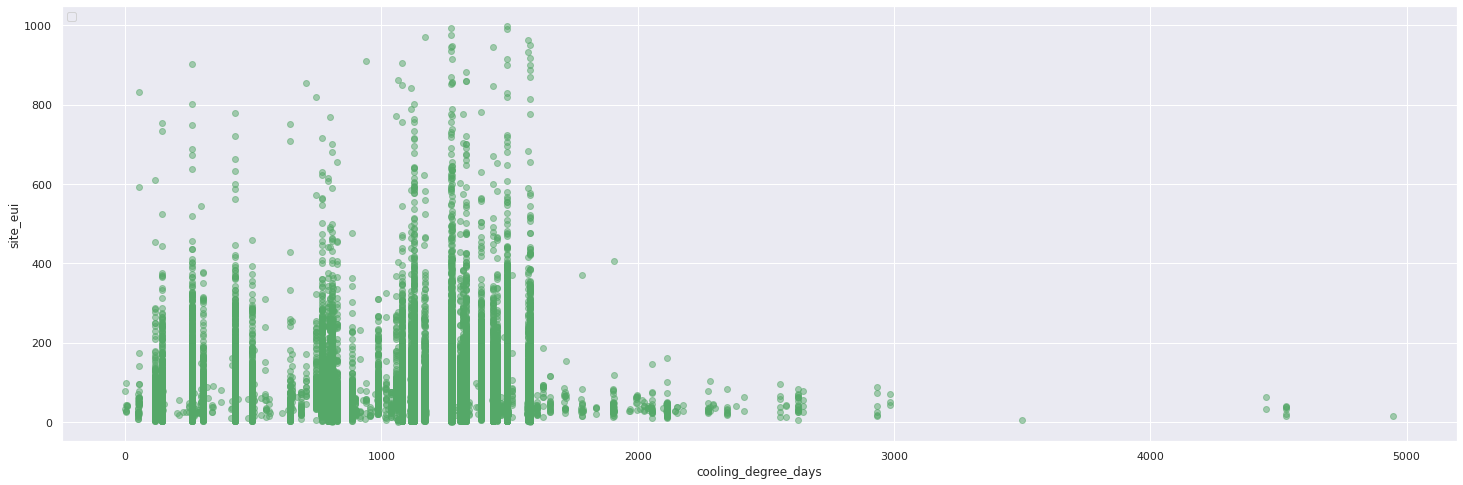

In [73]:
plt.scatter(train_df[f'cooling_degree_days'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel(f'cooling_degree_days')
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

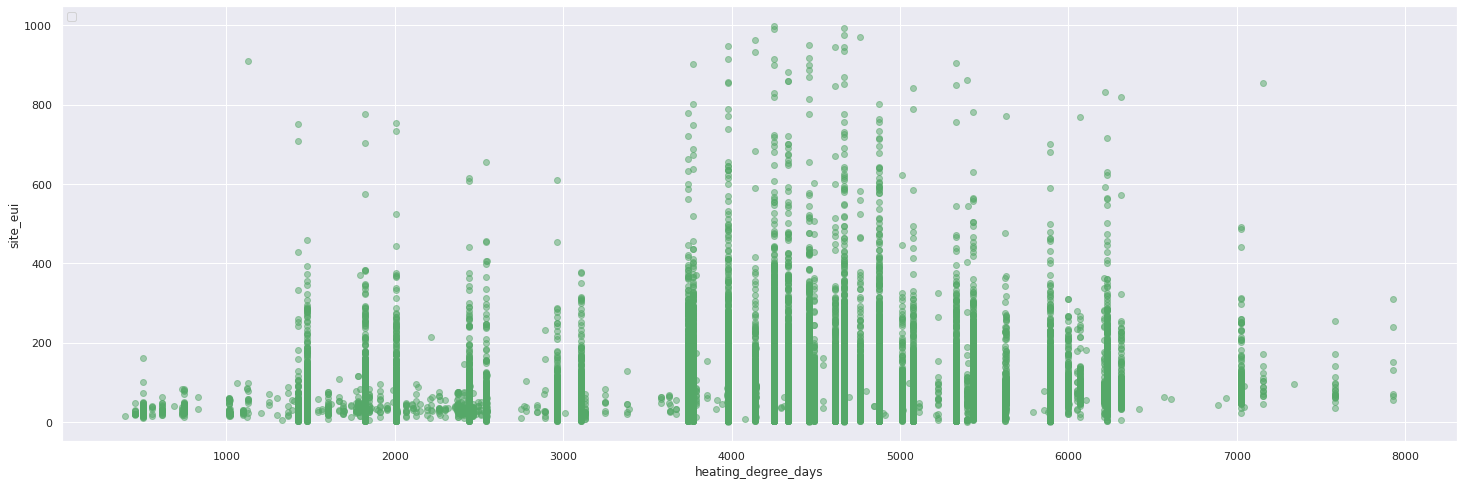

In [74]:
plt.scatter(train_df[f'heating_degree_days'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel(f'heating_degree_days')
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

ℹ️ It looks like an increase in heating_degree_days and cooling_degree_days reflects in an small increase in site_eui, however for cooling degreee days seems like the relationship is valid only when the variable is lower than 1500. 

## **2.11 Precipitation/Snowfall/Snowdepth inches**


In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int